# Mastodon analysis
Expected to be run in a notebook

[DuckDB in Jupyter Notebooks](https://duckdb.org/docs/guides/python/jupyter)

In [114]:
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

In [115]:
import duckdb
import pandas as pd
import seaborn as sns

# Import jupysql Jupyter extension to create SQL cells
%load_ext sql
%sql duckdb:///:memory:

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [116]:
%%sql
INSTALL httpfs;
LOAD httpfs;

""


In [117]:
%%sql
drop table if exists mastodon_toot_raw;
drop table if exists mastodon_toot;
drop table if exists language;

CREATE TABLE language(lang_iso VARCHAR PRIMARY KEY, language_name VARCHAR);

insert into language
select *
from read_csv('../duckdb/language.csv', AUTO_DETECT=TRUE, header=True);

create table mastodon_toot_raw as
select m_id
, created_at, ('EPOCH'::TIMESTAMP + INTERVAL (created_at::INT) seconds)::TIMESTAMPTZ  as created_tz
, app
, url
, regexp_replace(regexp_replace(url, '^http[s]://', ''), '/.*$', '') as from_instance
, base_url
, language
, favourites
, username
, bot
, tags
, characters
, mastodon_text
FROM read_parquet('../data_tmp/mastodon-topic*');

create table mastodon_toot as
select mr.*, ln.language_name
from mastodon_toot_raw mr left outer join language ln on (mr.language = ln.lang_iso);

,Count
0,931000


In [136]:
%%sql

select *
from  read_parquet('../data_tmp/mastodon-topic*')
where username = 'worldeconomicfella'
;

,m_id,created_at,created_at_str,app,url,base_url,language,favourites,username,bot,tags,characters,words,mastodon_text
0,109832377918139816,1675909087,2023 02 09 13:18:07,,https://nafo.uk/@worldeconomicfella/1098323768...,https://mastodon.social,nl,0,worldeconomicfella,False,1,252,32,RT Nafodog1#BREAKING 📌🇹🇷The family of 8 earthq...
1,109832378032950296,1675909088,2023 02 09 13:18:08,,https://nafo.uk/@worldeconomicfella/1098323769...,https://mastodon.social,nl,0,worldeconomicfella,False,1,252,32,RT Nafodog1#BREAKING 📌🇹🇷The family of 8 earthq...
2,109832381764060301,1675909145,2023 02 09 13:19:05,,https://nafo.uk/@worldeconomicfella/1098323806...,https://mastodon.social,nl,0,worldeconomicfella,False,1,252,32,RT Nafodog1#BREAKING 📌🇹🇷The family of 8 earthq...
3,109832381777969202,1675909146,2023 02 09 13:19:06,,https://nafo.uk/@worldeconomicfella/1098323807...,https://mastodon.social,nl,0,worldeconomicfella,False,1,252,32,RT Nafodog1#BREAKING 📌🇹🇷The family of 8 earthq...
4,109832385757027759,1675909206,2023 02 09 13:20:06,,https://nafo.uk/@worldeconomicfella/1098323847...,https://mastodon.social,nl,0,worldeconomicfella,False,1,252,32,RT Nafodog1#BREAKING 📌🇹🇷The family of 8 earthq...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,109832767258736553,1675915028,2023 02 09 14:57:08,,https://nafo.uk/@worldeconomicfella/1098327662...,https://mastodon.social,nl,0,worldeconomicfella,False,1,252,32,RT Nafodog1#BREAKING 📌🇹🇷The family of 8 earthq...
535,109832771010404322,1675915085,2023 02 09 14:58:05,,https://nafo.uk/@worldeconomicfella/1098327699...,https://mastodon.social,nl,0,worldeconomicfella,False,1,252,32,RT Nafodog1#BREAKING 📌🇹🇷The family of 8 earthq...
536,109832771095549258,1675915086,2023 02 09 14:58:06,,https://nafo.uk/@worldeconomicfella/1098327700...,https://mastodon.social,nl,0,worldeconomicfella,False,1,252,32,RT Nafodog1#BREAKING 📌🇹🇷The family of 8 earthq...
537,109832775092671772,1675915147,2023 02 09 14:59:07,,https://nafo.uk/@worldeconomicfella/1098327740...,https://mastodon.social,nl,0,worldeconomicfella,False,1,252,32,RT Nafodog1#BREAKING 📌🇹🇷The family of 8 earthq...


# The Mastodon app landscape
What clients are used to access mastodon instances

In [143]:
%%sql
mastodon_app_df << 
select *
from mastodon_toot
where app is not null 
and app <> ''
and app <> 'Web';

Returning data to local variable mastodon_app_df


<AxesSubplot: xlabel='count', ylabel='app'>

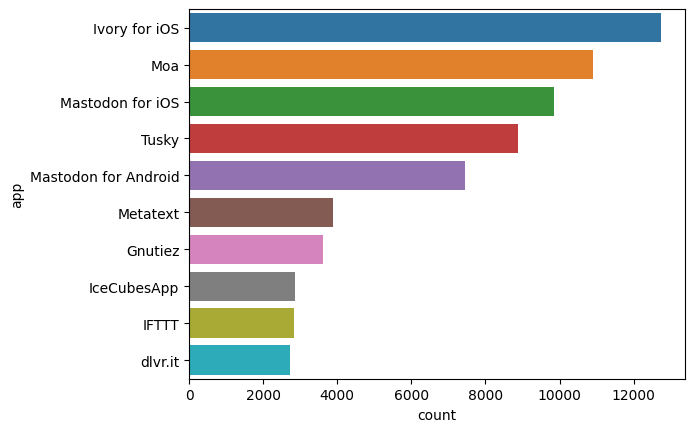

In [144]:
sns.countplot(data=mastodon_app_df, y="app", order=mastodon_app_df.app.value_counts().iloc[:10].index)

In [134]:
%%sql
select strftime(created_tz, '%Y/%m/%d %a') as created_day
, count(*) as num_toots
, count(distinct(username)) as num_users
, count(distinct(from_instance)) as num_urls
, mode(case when bot='False' then username end) as most_freq_non_bot
, mode(case when bot='True' then username end) as most_freq_bot
, mode(base_url) as most_freq_host
from mastodon_toot
group by 1
order by 1
;

,created_day,num_toots,num_users,num_urls,most_freq_non_bot,most_freq_bot,most_freq_host
0,2023/02/04 Sat,125977,34756,3514,IzumiHal,hkgpress,https://mastodon.social
1,2023/02/05 Sun,207464,49241,4310,gnutiez,ua,https://mastodon.social
2,2023/02/06 Mon,45293,17846,2255,gnutiez,nieuws,https://mastodon.social
3,2023/02/07 Tue,106522,30701,3350,gnutiez,cnexnews,https://mastodon.social
4,2023/02/08 Wed,204744,49649,4372,gnutiez,cnexnews,https://mastodon.social
5,2023/02/09 Thu,166096,48532,4227,worldeconomicfella,cnexnews,https://mastodon.social
6,2023/02/10 Fri,74904,29111,3092,bloombergnews,cnexnews,https://mastodon.social


In [150]:
%%sql
select username
, count(*) as num_toots
from mastodon_toot
where language = 'en'
and bot = 'False'
group by 1 
having count(*) >500
order by 2 desc
;

,username,num_toots
0,realTuckFrumper,2149
1,ajm_radio,1608
2,bloombergnews,1341
3,SocraticEthics,1069
4,baritonekun,1024
5,angsuman,885
6,232k_s,805
7,gratefuldread,684
8,kanakghosh,627
9,alojapan,592


In [151]:
%%sql
select *
from mastodon_toot
where username = 'georgespolitzer'
;

,m_id,created_at,created_tz,app,url,from_instance,base_url,language,favourites,username,bot,tags,characters,mastodon_text,language_name
0,109834883567519954,1675947320,2023-02-09 12:55:20,,https://monads.online/@georgespolitzer/1098348...,monads.online,https://mastodon.social,en,0,georgespolitzer,False,0,67,the classic rock station played californicatio...,English
1,109828027783780921,1675842709,2023-02-08 07:51:49,,https://monads.online/@georgespolitzer/1098280...,monads.online,https://mastodon.social,en,0,georgespolitzer,False,0,98,is making this a free speech issue really the ...,English
2,109828028878056973,1675842726,2023-02-08 07:52:06,,https://monads.online/@georgespolitzer/1098280...,monads.online,https://mastodon.social,en,0,georgespolitzer,False,0,14,kitty :salute:,English
3,109828035512667129,1675842827,2023-02-08 07:53:47,,https://monads.online/@georgespolitzer/1098280...,monads.online,https://mastodon.social,en,0,georgespolitzer,False,0,49,can't state enough how fucking epic this is to me,English
4,109828040531229735,1675842904,2023-02-08 07:55:04,,https://monads.online/@georgespolitzer/1098280...,monads.online,https://mastodon.social,en,0,georgespolitzer,False,0,48,"enough about mankind, let's hear about womanmean",English
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,109834190000470298,1675936737,2023-02-09 09:58:57,,https://monads.online/@georgespolitzer/1098341...,monads.online,https://mastodon.social,en,0,georgespolitzer,False,0,81,it's so funny to me that the only alcohol my m...,English
501,109834191180541377,1675936755,2023-02-09 09:59:15,,https://monads.online/@georgespolitzer/1098341...,monads.online,https://mastodon.social,en,0,georgespolitzer,False,0,52,she didn't even know that cinnamon liquor is c...,English
502,109803530775376536,1675468914,2023-02-04 00:01:54,,https://monads.online/@georgespolitzer/1098035...,monads.online,https://mastodon.social,en,0,georgespolitzer,False,0,24,tv tropes sucks Ass lmao,English
503,109803533957776427,1675468963,2023-02-04 00:02:43,,https://monads.online/@georgespolitzer/1098035...,monads.online,https://mastodon.social,en,0,georgespolitzer,False,0,166,I don't have daddy issues because I never had ...,English


In [137]:
%%sql
mastodon_usage_df << 
select strftime(created_tz, '%Y/%m/%d %a') as created_day
, date_part('hour', created_tz) as created_hour
, count(*) as num
from mastodon_toot
group by 1,2 
order by 1,2
;

Returning data to local variable mastodon_usage_df


<AxesSubplot: xlabel='created_hour', ylabel='num'>

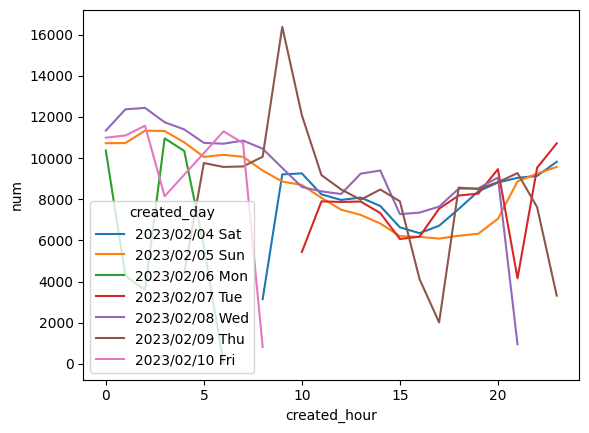

In [138]:
# sns.lineplot(data=mastodon_usage_df, x="created_hour", y="num")
sns.lineplot(data=mastodon_usage_df, x="created_hour", y="num", hue="created_day")

# Language usage
A wildly inaccurate investigation of language tags

In [139]:
%%sql
mastodon_usage_df << 
select *
from mastodon_toot;

Returning data to local variable mastodon_usage_df


<AxesSubplot: xlabel='count', ylabel='language_name'>

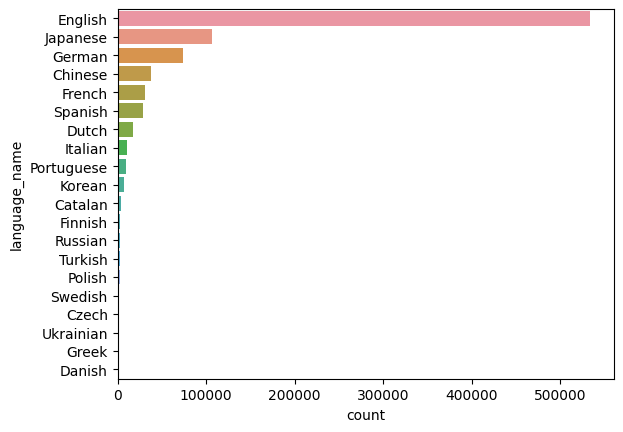

In [140]:
sns.countplot(data=mastodon_usage_df, y="language_name", order=mastodon_usage_df.language_name.value_counts().iloc[:20].index)

In [141]:
%%sql
mastodon_lang_df << 
select *
from mastodon_toot
where characters < 200
and language not in ('unknown');

Returning data to local variable mastodon_lang_df


<AxesSubplot: xlabel='characters', ylabel='language_name'>

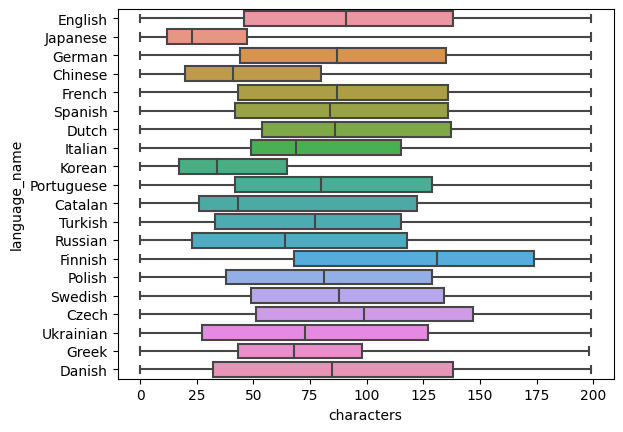

In [142]:
sns.boxplot(data=mastodon_lang_df, x="characters", y="language_name", whis=100, orient="h", order=mastodon_lang_df.language_name.value_counts().iloc[:20].index)
